# Imports

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Read Data

In [3]:
feature_df = pd.read_csv('../data/dailyActivity_merged.csv')
target_df = pd.read_csv('../data/sleepDay_merged.csv')

In [4]:
print("unique ids:", feature_df.Id.nunique())
print("Total Days :", pd.to_datetime(feature_df['ActivityDate']).max()-pd.to_datetime(feature_df['ActivityDate']).min())

unique ids: 33
Total Days : 30 days 00:00:00


In [25]:
min_date = pd.to_datetime(feature_df['ActivityDate']).min()
feature_df['day'] = feature_df['ActivityDate'].apply(lambda x: (pd.to_datetime(x) - min_date).days)
target_df['day'] = target_df['SleepDay'].apply(lambda x: (pd.to_datetime(x) - min_date).days)

In [26]:
df = feature_df.merge( target_df, on=['Id','day'],how='inner')
df= df[df['day']<=15]
print("unique ids:", df.Id.nunique())
print("Total Days :", pd.to_datetime(df['ActivityDate']).max()-pd.to_datetime(df['ActivityDate']).min())

unique ids: 23
Total Days : 15 days 00:00:00


In [27]:

feature_columns = ['TotalSteps', 'TotalDistance', 'TrackerDistance', 'LoggedActivitiesDistance', 'VeryActiveDistance',
                   'ModeratelyActiveDistance', 'LightActiveDistance', 'SedentaryActiveDistance', 'VeryActiveMinutes',
                   'FairlyActiveMinutes', 'LightlyActiveMinutes', 'SedentaryMinutes','TotalMinutesAsleep']  # Add your features here

# Make sure 'day' is treated as a categorical feature, and we pivot based on it
# 
df_pivoted = df.groupby(['Id','day'],as_index=False).agg({a:'mean' for a in feature_columns})
df_pivoted = df_pivoted.pivot(index='Id', columns='day', values=feature_columns)
df_pivoted.columns = ['_'.join(map(str, col)) for col in df_pivoted.columns]

y = df_pivoted[[x for x in df_pivoted.columns if 'TotalMinutesAsleep' in x]].mean(axis=1).to_numpy() # averagae sleep time
df_pivoted = df_pivoted.fillna(0)
X = df_pivoted[[x for x in df_pivoted.columns if 'TotalMinutesAsleep' not in x]].to_numpy().reshape((df_pivoted.shape[0],16, len(feature_columns)-1))


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
print(X_test.shape,X_train.shape)

(5, 16, 12) (18, 16, 12)


# Train Model

c:\Users\abhis\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - loss: 15850.7090
Test Loss: 15850.708984375


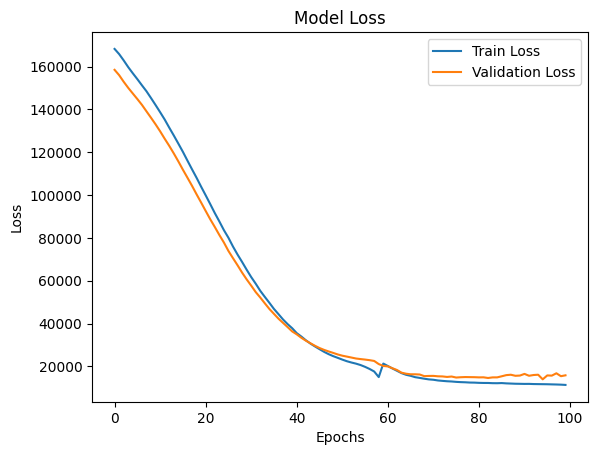

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


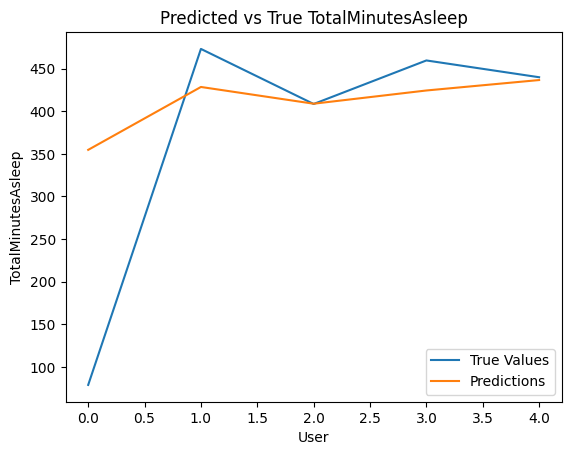

In [29]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), activation='tanh'))
model.add(LSTM(50, return_sequences=False, activation='tanh'))
model.add(Dense(10,activation='relu'))
model.add(Dense(1,activation='linear'))  # Output layer (predicting TotalMinutesAsleep)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 7: Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=1, validation_data=(X_test, y_test), verbose=0)

# Step 8: Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Step 9: Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Step 10: Make predictions
predictions = model.predict(X_test)


# Plot predictions vs actual values
plt.plot(y_test, label='True Values')
plt.plot(predictions, label='Predictions')
plt.title('Predicted vs True TotalMinutesAsleep')
plt.xlabel('User')
plt.ylabel('TotalMinutesAsleep')
plt.legend()
plt.show()

In [30]:
model.save("../models/baseline.keras")